<a href="https://colab.research.google.com/github/Rafi076/RTFER_Framework/blob/main/RTFER_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!git clone https://github.com/Rafi076/RTFER_Framework.git

fatal: destination path 'RTFER_Framework' already exists and is not an empty directory.


In [27]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# STEP 2: Correct zip path (case-sensitive, and spelling checked)
zip_path = '/content/drive/MyDrive/RTFER_Framwork/FER-2013.zip'
extract_to = '/content'  # Since zip already has a folder inside, extract to /content

# STEP 3: Unzip
import zipfile, os

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Unzipped successfully!")


✅ Unzipped successfully!


In [29]:
# Show contents of the extracted folder
!ls "/content/FER-2013"

test  train


**Step 3: Import Libraries**

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix


**Step 4: Define Transforms for Data Augmentation**

In [31]:


# ✅ Final Step 4:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(48, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


test_transforms = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # for 3 channels
])


**Step 5: Load the Dataset**

We load images using ImageFolder.

In [32]:
from torch.utils.data import Subset, DataLoader
import numpy as np

train_dir = "/content/FER-2013/train"
test_dir = "/content/FER-2013/test"

# Apply transforms
train_data_full = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

# ✅ Reduce training dataset size (use 8000 samples for faster training)
subset_size = 8000  # You can try 5000 for even faster training
train_subset_indices = list(range(subset_size))
train_data = Subset(train_data_full, train_subset_indices)

# ✅ Class names (from full set, safe to use)
class_names = train_data_full.classes
print("Classes:", class_names)

# ✅ Split into train and val
val_percent = 0.1  # 10% for validation
num_val = int(len(train_data) * val_percent)
indices = np.random.permutation(len(train_data))

val_indices = indices[:num_val]
train_indices = indices[num_val:]

train_subset = Subset(train_data, train_indices)
val_subset = Subset(train_data, val_indices)

# ✅ Use larger batch size for speed (if memory allows)
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


**Step 6: Visualize Sample Images**

Before training, let’s confirm that the images and labels are loading correctly:

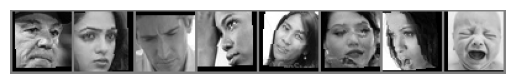

angry angry fear fear angry fear fear angry


In [33]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Helper function to show image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Show labels
print(' '.join(f'{class_names[labels[j]]}' for j in range(8)))


**Step 7: Build the CNN Model**

We’ll start with a simple custom CNN model. Later, we can improve it or use pretrained models like ResNet.

In [34]:
from torchvision import models
import torch.nn as nn

class ResNetFER(nn.Module):
    def __init__(self):
        super(ResNetFER, self).__init__()
        self.model = models.resnet18(pretrained=True)  # keep pretrained weights
        self.model.fc = nn.Linear(self.model.fc.in_features, 7)  # 7 emotions

    def forward(self, x):
        return self.model(x)


**Step 8: Define Loss, Optimizer, and Move Model to GPU**

In [35]:
# ✅ Step 8: Model setup, optimizer, loss, scheduler, early stopping

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetFER().to(device)

# 🔧 Enable cuDNN auto-tuner for faster training on GPU
torch.backends.cudnn.benchmark = True

# 🔒 Freeze all pretrained layers
for param in model.model.parameters():
    param.requires_grad = False

# 🔓 Unfreeze deeper layers for fine-tuning
for param in model.model.layer3.parameters():
    param.requires_grad = True
for param in model.model.layer4.parameters():
    param.requires_grad = True
for param in model.model.fc.parameters():
    param.requires_grad = True

# ✅ Optimizer & Loss
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4, weight_decay=1e-4
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Optional but helps

# ✅ Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

# ✅ Early stopping config
best_val_acc = 0.0
patience = 5
patience_counter = 0
best_model_state = None


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Step 9: Train the Model**

Let’s train for 10 epochs and monitor loss and accuracy.

In [36]:
from tqdm import tqdm

epochs = 25
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # === VALIDATION ===
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}, "
          f"Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # === EARLY STOPPING ===
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🔥 Early stopping triggered at epoch {epoch+1}")
            break

# Restore the best model
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"✅ Best model restored with val accuracy: {best_val_acc:.2f}%")


Epoch 1/25: 100%|██████████| 57/57 [02:11<00:00,  2.30s/it]


Epoch 1, Train Loss: 74.0650, Train Acc: 52.67%, Val Loss: 8.3179, Val Acc: 53.62%


Epoch 2/25: 100%|██████████| 57/57 [02:10<00:00,  2.30s/it]


Epoch 2, Train Loss: 63.7347, Train Acc: 58.33%, Val Loss: 8.4049, Val Acc: 55.38%


Epoch 3/25: 100%|██████████| 57/57 [02:09<00:00,  2.27s/it]


Epoch 3, Train Loss: 60.7051, Train Acc: 62.12%, Val Loss: 7.8191, Val Acc: 58.75%


Epoch 4/25: 100%|██████████| 57/57 [02:11<00:00,  2.30s/it]


Epoch 4, Train Loss: 60.4162, Train Acc: 63.50%, Val Loss: 7.8746, Val Acc: 58.75%


Epoch 5/25: 100%|██████████| 57/57 [02:10<00:00,  2.30s/it]


Epoch 5, Train Loss: 58.4958, Train Acc: 65.60%, Val Loss: 7.3783, Val Acc: 61.62%


Epoch 6/25: 100%|██████████| 57/57 [02:10<00:00,  2.29s/it]


Epoch 6, Train Loss: 57.3087, Train Acc: 67.61%, Val Loss: 7.4086, Val Acc: 62.62%


Epoch 7/25: 100%|██████████| 57/57 [02:10<00:00,  2.29s/it]


Epoch 7, Train Loss: 55.5965, Train Acc: 69.43%, Val Loss: 7.2591, Val Acc: 64.50%


Epoch 8/25: 100%|██████████| 57/57 [02:09<00:00,  2.27s/it]


Epoch 8, Train Loss: 55.5497, Train Acc: 70.24%, Val Loss: 7.4729, Val Acc: 63.12%


Epoch 9/25: 100%|██████████| 57/57 [02:10<00:00,  2.29s/it]


Epoch 9, Train Loss: 53.7736, Train Acc: 71.58%, Val Loss: 7.3397, Val Acc: 63.88%


Epoch 10/25: 100%|██████████| 57/57 [02:10<00:00,  2.30s/it]


Epoch 10, Train Loss: 52.9072, Train Acc: 73.00%, Val Loss: 7.2811, Val Acc: 64.62%


Epoch 11/25: 100%|██████████| 57/57 [02:11<00:00,  2.30s/it]


Epoch 11, Train Loss: 51.8158, Train Acc: 73.97%, Val Loss: 7.1648, Val Acc: 65.38%


Epoch 12/25: 100%|██████████| 57/57 [02:11<00:00,  2.31s/it]


Epoch 12, Train Loss: 50.8187, Train Acc: 75.18%, Val Loss: 7.2439, Val Acc: 64.62%


Epoch 13/25: 100%|██████████| 57/57 [02:10<00:00,  2.30s/it]


Epoch 13, Train Loss: 50.0332, Train Acc: 76.39%, Val Loss: 7.1865, Val Acc: 65.75%


Epoch 14/25: 100%|██████████| 57/57 [02:10<00:00,  2.30s/it]


Epoch 14, Train Loss: 49.2122, Train Acc: 77.50%, Val Loss: 7.1900, Val Acc: 67.38%


Epoch 15/25: 100%|██████████| 57/57 [02:10<00:00,  2.29s/it]


Epoch 15, Train Loss: 48.7214, Train Acc: 77.97%, Val Loss: 7.1776, Val Acc: 66.12%


Epoch 16/25: 100%|██████████| 57/57 [02:09<00:00,  2.27s/it]


Epoch 16, Train Loss: 47.5888, Train Acc: 79.21%, Val Loss: 7.2133, Val Acc: 67.38%


Epoch 17/25: 100%|██████████| 57/57 [02:09<00:00,  2.27s/it]


Epoch 17, Train Loss: 47.4789, Train Acc: 79.56%, Val Loss: 6.9787, Val Acc: 70.25%


Epoch 18/25: 100%|██████████| 57/57 [02:10<00:00,  2.29s/it]


Epoch 18, Train Loss: 46.0112, Train Acc: 80.99%, Val Loss: 7.2565, Val Acc: 70.50%


Epoch 19/25: 100%|██████████| 57/57 [02:11<00:00,  2.31s/it]


Epoch 19, Train Loss: 45.7778, Train Acc: 81.39%, Val Loss: 7.1322, Val Acc: 69.88%


Epoch 20/25: 100%|██████████| 57/57 [02:10<00:00,  2.30s/it]


Epoch 20, Train Loss: 44.6861, Train Acc: 81.97%, Val Loss: 7.2921, Val Acc: 70.00%


Epoch 21/25: 100%|██████████| 57/57 [02:11<00:00,  2.30s/it]


Epoch 21, Train Loss: 44.8906, Train Acc: 81.99%, Val Loss: 7.1465, Val Acc: 67.62%


Epoch 22/25: 100%|██████████| 57/57 [02:10<00:00,  2.29s/it]


Epoch 22, Train Loss: 42.6001, Train Acc: 84.69%, Val Loss: 6.8154, Val Acc: 71.25%


Epoch 23/25: 100%|██████████| 57/57 [02:10<00:00,  2.30s/it]


Epoch 23, Train Loss: 41.4831, Train Acc: 86.11%, Val Loss: 7.1466, Val Acc: 70.75%


Epoch 24/25: 100%|██████████| 57/57 [02:11<00:00,  2.30s/it]


Epoch 24, Train Loss: 41.5544, Train Acc: 85.83%, Val Loss: 7.1429, Val Acc: 66.50%


Epoch 25/25: 100%|██████████| 57/57 [02:11<00:00,  2.30s/it]


Epoch 25, Train Loss: 41.2650, Train Acc: 86.31%, Val Loss: 6.8772, Val Acc: 70.50%
✅ Best model restored with val accuracy: 71.25%
